Over Sampling+FE+Standardization+Model

1. Import necessary Libraries

In [38]:
#For computational and random seed purpose
import numpy as np
np.random.seed(42)
#to read csv file
import pandas as pd
#To split into train and cv data
from sklearn.model_selection import train_test_split
#To compute AUROC
from sklearn.metrics import auc,roc_auc_score
#for AUROC graph
import matplotlib.pyplot as plt
#for oversampling technique
from imblearn.over_sampling import SMOTE # (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
#Data is imbalanced, we need calibrated model
from sklearn.calibration import CalibratedClassifierCV
#for hyperparameter tuning and Cross-validation fold
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
#to ignore the error message
import warnings
warnings.filterwarnings("ignore")
#for heatmap and other plotting technique
import seaborn as sns
#to strandize the real value data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
#To create Knn model on datasets
from sklearn.neighbors import KNeighborsClassifier
#for roc_curve
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

import eli5
from eli5.sklearn import PermutationImportance
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from scipy.stats import kurtosis
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler

In [39]:
#locate parent directory
data_dir = "./"

#Read the training data
df_train = pd.read_csv('train.csv')
print(df_train)


      id  target      0      1      2  ...    295    296    297    298    299
0      0     1.0 -0.098  2.165  0.681  ... -2.097  1.051 -0.414  1.038 -1.065
1      1     0.0  1.081 -0.973 -0.383  ... -1.624 -0.458 -1.099 -0.936  0.973
2      2     1.0 -0.523 -0.089 -0.348  ... -1.165 -1.544  0.004  0.800 -1.211
3      3     1.0  0.067 -0.021  0.392  ...  0.467 -0.562 -0.254 -0.533  0.238
4      4     1.0  2.347 -0.831  0.511  ...  1.378  1.246  1.478  0.428  0.253
..   ...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
245  245     0.0 -1.199  0.466 -0.908  ... -0.243  0.525  0.281 -0.255 -1.136
246  246     0.0  0.237  0.233 -0.380  ...  1.004 -0.979  0.007  0.112 -0.558
247  247     0.0  1.411 -1.465  0.119  ... -0.727  0.461  0.760  0.168 -0.719
248  248     1.0  0.620  1.040  0.184  ...  0.478 -0.910 -0.805  2.029 -0.423
249  249     0.0  0.489  0.403  0.139  ...  0.812  0.269 -1.454 -0.625  1.474

[250 rows x 302 columns]


In [40]:
#Read test data
df_test = pd.read_csv('test.csv')
df_test

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-1.791,0.122,-0.669,-1.558,-0.244,2.583,-0.829,0.133,-2.746,0.341,-1.145,0.492,0.437,-0.628,0.271,2.639,0.481,-0.687,1.017,1.648,-1.272,-0.797,-0.870,-1.582,-1.987,-0.052,-0.194,0.539,-1.788,-0.433,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-1.167,1.009,-0.180,-0.683,-1.383,1.020,0.268,-1.558,0.620,-0.489,-2.090,-0.977,1.672,-0.655,-0.801,-1.846,0.761,-0.846,0.181,0.962,-0.611,1.450,0.021,0.320,-0.951,-2.662,0.761,-0.665,-0.619,-0.645,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-1.029,-0.340,0.052,2.122,-0.136,-1.799,1.450,1.866,-0.273,-0.237,-0.207,-0.196,-1.106,-1.560,-0.934,2.167,0.323,0.583,1.480,-0.685,-0.473,-1.066,-0.271,0.506,-0.753,1.048,-0.450,-0.300,-1.221,0.235,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,-0.486,-0.068,-0.534,-1.322,0.500,0.263,-0.745,0.578,-0.064,0.738,-0.280,0.745,-0.588,-0.429,-0.588,0.154,-1.187,1.681,-0.832,-0.437,-0.038,-1.096,-0.156,3.565,-0.428,-0.384,1.243,-0.966,1.525,0.458,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,19995,1.069,0.517,-0.690,0.241,0.913,-0.859,0.093,-0.359,-0.047,0.713,2.191,0.774,-0.110,-0.721,0.375,0.577,-0.192,-1.345,0.042,0.786,0.774,2.458,0.634,-0.664,-0.486,0.136,-0.506,0.509,-2.206,-1.035,-0.828,0.335,-0.963,0.946,1.728,0.256,-0.938,0.041,-0.112,...,-0.079,-0.853,0.708,0.301,0.636,-0.688,0.220,-1.192,1.257,-0.664,-1.258,-1.199,-0.145,0.581,-0.613,2.775,-0.254,-0.027,-1.088,-0.461,-0.356,-0.622,-0.228,-0.490,1.011,0.655,1.088,-0.796,-0.261,-1.219,0.495,1.021,0.126,-0.353,-0.092,0.996,-0.381,-0.748,1.567,1.165
19746,19996,-0.529,0.438,0.672,1.436,-0.720,0.698,-0.350,2.150,-1.241,-0.167,-0.188,0.541,-0.392,1.727,-0.965,0.550,-2.164,-0.523,-0.144,-0.931,0.703,0.464,-0.919,-0.867,-1.345,-0.634,0.121,0.877,-1.665,-0.086,-0.703,-0.874,0.676,1.671,0.356,0.365,-

In [41]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

### Observation

We have read the training and test dataset. After reading both of dataset, we got it know that test dataset is having more features compare to training dataset

In [42]:
def feature_engg(df,test=False):
  '''
  perform feature Engieering in basic statistics, trignometory, hyperbolic and exponential function

  parameters:

  '''
  if test:
    data = df.drop(['id'],axis=1)
  else:
    data = df.drop(['id','target'],axis=1)
  
  #mean and std
  df['mean'] = np.mean(data,axis=1) # taking mean value along with column
  df['std'] = np.std(data,axis=1) # taking std along with column
  df['median'] = np.median(data,axis=1)
  df['min'] = np.min(data,axis=1)
  df['max'] = np.max(data,axis=1)

 
  # applying trignometric function
  df['sin_mean'] = np.sin(df['mean'])
  df['cos_mean'] = np.cos(df['mean'])
  df['tan_mean'] = np.tan(df['mean'])
  df['sin_std'] = np.sin(df['std'])
  df['cos_std'] = np.cos(df['std'])
  df['tan_std'] = np.tan(df['std'])

  df['sin_median'] = np.sin(df['median'])
  df['cos_median'] = np.cos(df['median'])
  df['tan_median'] = np.tan(df['median'])
  sin_data = np.sin(data) #calculated the sin_data
  cos_data = np.cos(data) #calculated the cos_data
  tan_data = np.tan(data) #calculated the tan_data

  df['mean_sin'] = np.mean(sin_data,axis=1) #calculating the mean of sin_data
  df['mean_cos'] = np.mean(cos_data,axis=1) #calculating the mean of cos_data
  df['mean_tan'] = np.mean(tan_data,axis=1) #calculating the mean of tan_data

  #hyperbolic function

  sinh_data = np.sinh(data)
  cosh_data = np.cosh(data)
  tanh_data = np.tanh(data)
  arcsinh_data = np.arcsinh(data)
  arccosh_data = np.arccosh(data)
 
  df['mean_sinh'] = np.mean(sinh_data,axis=1)
  df['mean_cosh'] = np.mean(cosh_data,axis=1)
  df['mean_tanh'] = np.mean(tanh_data,axis=1)
  df['mean_arsinh'] = np.mean(arcsinh_data,axis=1)
  df['mean_arcosh'] = np.mean(arccosh_data,axis=1)
  df['sinh_mean'] = np.sinh(df['mean'])

  df['tanh_mean'] = np.tanh(df['mean'])
  df['arsinh_mean'] = np.arcsinh(df['mean'])
  df['sinh_std'] = np.sinh(df['std'])
  df['cosh_std'] = np.cosh(df['std'])
  df['tanh_std'] = np.tanh(df['std'])
  df['sinh_median'] = np.sinh(df['median'])
  df['cosh_median'] = np.cosh(df['median'])
  df['tanh_median'] = np.tanh(df['median'])

#exponential function


  exp_data = np.exp(data)
  expm1_data = np.expm1(data)
  exp2_data = np.exp2(data)

  df['mean_exp'] = np.mean(exp_data,axis=1)
  df['mean_expm1'] = np.mean(expm1_data,axis=1)
  df['mean_exp2'] = np.mean(exp2_data,axis=1)
  df['exp1_mean'] = np.exp(df['mean'])
  df['expm1_mean'] = np.expm1(df['mean'])
  df['exp2_mean'] = np.exp2(df['mean'])
  df['exp1_median'] = np.exp(df['median'])
  df['expm1_median'] = np.expm1(df['median'])
  df['exp2_median'] = np.exp2(df['median'])

  df['exp1_std'] = np.exp(df['std'])
  df['expm1_std'] = np.expm1(df['std'])
  df['exp2_std'] = np.exp2(df['std'])
  # Polynomial FE
  # X**2
  df['mean_x2'] = np.mean(np.power(data,2), axis=1)
  # X**3
  df['mean_x3'] = np.mean(np.power(data,3), axis=1)
  # X**4
  df['mean_x4'] = np.mean(np.power(data,4), axis=1)
  # X**5
  df['mean_x5'] = np.mean(np.power(data,5), axis=1)
  # X**6
  df['mean_x6'] = np.mean(np.power(data,6), axis=1)
  # X**7
  df['mean_x7'] = np.mean(np.power(data,7), axis=1)
  #logithm FE
  df['x2_mean'] = np.power(df['mean'],2)
  # X**3
  df['x3_mean'] = np.power(df['mean'],3)
  # X**4
  df['x4_mean'] = np.power(df['mean'],4)
  # X**5
  df['x5_mean'] = np.power(df['mean'],5)
  # X**6
  df['x6_mean'] = np.power(df['mean'],6)
  # X**7
  df['x7_mean'] = np.power(df['mean'],7)
  #skewness and kurtosis
  skew_data = skew(data)
  kurtosis_data = kurtosis(data)
  df['skewness'] = np.mean(skew_data)

  df['kurtosis'] = np.mean(kurtosis_data)
  data['mean_skewness'] = skew(df['mean'])
  data['mean_kurtosis'] = kurtosis(df['mean'])
  df['x2_median'] = np.power(df['median'],2)
  # X**3
  df['x3_median'] = np.power(df['median'],3)
  # X**4
  df['x4_median'] = np.power(df['median'],4)
  # X**5
  df['x5_median'] = np.power(df['median'],5)
  # X**6
  df['x6_median'] = np.power(df['median'],6)
  # X**7
  df['x7_median'] = np.power(df['median'],7)
  
 
  return df

In [43]:
df_train = feature_engg(df_train)
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,tanh_mean,arsinh_mean,sinh_std,cosh_std,tanh_std,sinh_median,cosh_median,tanh_median,mean_exp,mean_expm1,mean_exp2,exp1_mean,expm1_mean,exp2_mean,exp1_median,expm1_median,exp2_median,exp1_std,expm1_std,exp2_std,mean_x2,mean_x3,mean_x4,mean_x5,mean_x6,mean_x7,x2_mean,x3_mean,x4_mean,x5_mean,x6_mean,x7_mean,skewness,kurtosis,x2_median,x3_median,x4_median,x5_median,x6_median,x7_median
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.009223,-0.009223,1.314655,1.651762,0.795911,-0.050521,1.001275,-0.050457,1.760647,0.760647,1.315869,0.990819,-0.009181,0.993627,0.950754,-0.049246,0.965602,2.966416,1.966416,2.124841,1.182425,0.015243,3.584848,0.196701,16.002542,2.376185,0.000085,-7.846278e-07,7.236884e-09,-6.674819e-11,6.156408e-13,-5.678261e-15,-0.003112,-0.048257,0.002550,-0.000129,6.503775e-06,-3.284406e-07,1.658625e-08,-8.376057e-10
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.085918,0.086024,1.150957,1.524697,0.754876,0.074569,1.002776,0.074362,1.712292,0.712292,1.324817,1.089948,0.089948,1.061519,1.077345,0.077345,1.052996,2.675654,1.675654,1.978208,0.976056,0.047272,2.766570,-0.411514,12.452285,-3.659986,0.007418,6.389448e-04,5.503232e-05,4.739933e-06,4.082505e-07,3.516261e-08,-0.003112,-0.048257,0.005550,0.000413,3.080528e-05,2.294993e-06,1.709770e-07,1.273778e-08
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,0.027650,0.027653,1.192353,1.556183,0.766203,0.028504,1.000406,0.028492,1.749107,0.749107,1.313960,1.028043,0.028043,1.019355,1.028910,0.028910,1.019951,2.748535,1.748535,2.015403,1.023024,0.266454,3.092631,1.535791,14.309247,8.480497,0.000765,2.115434e-05,5.850586e-07,1.618077e-08,4.475062e-10,1.237653e-11,-0.003112,-0.048257,0.000812,0.000023,6.597501e-07,1.880288e-08,5.358820e-10,1.527264e-11
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,0.088127,0.088242,1.081987,1.473328,0.734383,0.153092,1.011651,0.151329,1.752101,0.752101,1.326229,1.092378,0.092378,1.063158,1.164742,0.164742,1.111494,2.555315,1.555315,1.916104,0.887980,0.371308,2.553467,2.886702,13.629316,25.513723,0.007807,6.897917e-04,6.094770e-05,5.385135e-06,4.758126e-07,4.204122e-08,-0.003112,-0.048257,0.023256,0.003547,5.408532e-04,8.248011e-05,1.257822e-05,1.918178e-06
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,0.133610,0.134012,1.084244,1.474986,0.735087,0.112234,1.006279,0.111534,1.861741,0.861741,1.377569,1.143866,0.143866,1.097646,1.118513,0.118513,1.080725,2.559230,1.559230,1.918138,0.901115,0.613952,2.671541,3.973544,14.164592,32.381277,0.018067,2.428438e-03,3.264145e-04,4.387446e-05,5.897312e-06,7.926774e-07,-0.003112,-0.048257,0.012544,0.001405,1.573519e-04,1.762342e-05,1.973823e-06,2.210681e-07


In [44]:
df_test = feature_engg(df_test,True)
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,tanh_mean,arsinh_mean,sinh_std,cosh_std,tanh_std,sinh_median,cosh_median,tanh_median,mean_exp,mean_expm1,mean_exp2,exp1_mean,expm1_mean,exp2_mean,exp1_median,expm1_median,exp2_median,exp1_std,expm1_std,exp2_std,mean_x2,mean_x3,mean_x4,mean_x5,mean_x6,mean_x7,x2_mean,x3_mean,x4_mean,x5_mean,x6_mean,x7_mean,skewness,kurtosis,x2_median,x3_median,x4_median,x5_median,x6_median,x7_median
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.151117,0.151701,1.146373,1.521240,0.753578,0.219219,1.023747,0.214134,1.904397,0.904397,1.404195,1.164490,0.164490,1.111327,1.242965,0.242965,1.162717,2.667613,1.667613,1.974085,0.985912,0.477020,2.913247,3.188843,15.647366,28.824976,0.023190,3.531483e-03,5.377860e-04,8.189585e-05,1.247137e-05,1.899182e-06,-0.001176,-0.001081,0.047306,0.010289,2.237881e-03,4.867392e-04,1.058658e-04,2.302581e-05
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-0.032775,-0.032781,1.246750,1.598245,0.780075,-0.045516,1.001035,-0.045469,1.642217,0.642217,1.265487,0.967745,-0.032255,0.977530,0.955520,-0.044480,0.968954,2.844995,1.844995,2.064169,1.094274,-0.128315,3.281111,-1.055412,15.260276,-10.222569,0.001075,-3.524454e-05,1.155551e-06,-3.788666e-08,1.242177e-09,-4.072685e-11,-0.001176,-0.001081,0.002070,-0.000094,4.285935e-06,-1.950100e-07,8.872957e-09,-4.037195e-10
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-0.049337,-0.049357,1.168915,1.538298,0.759875,0.012500,1.000078,0.012499,1.517775,0.517775,1.214393,0.951823,-0.048177,0.966354,1.012578,0.012578,1.008702,2.707213,1.707213,1.994352,0.994294,-0.330590,3.062801,-2.662855,15.657375,-21.577532,0.002438,-1.203830e-04,5.944113e-06,-2.935005e-07,1.449208e-08,-7.155704e-10,-0.001176,-0.001081,0.000156,0.000002,2.441406e-08,3.051758e-10,3.814697e-12,4.768372e-14
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-0.008706,-0.008707,1.141207,1.517350,0.752105,0.027503,1.000378,0.027493,1.566765,0.566765,1.243412,0.991331,-0.008669,0.993983,1.027882,0.027882,1.019244,2.658557,1.658557,1.969437,0.956136,-0.076546,2.382968,-0.165130,8.197568,-0.044153,0.000076,-6.600180e-07,5.746556e-09,-5.003335e-11,4.356237e-13,-3.792830e-15,-0.001176,-0.001081,0.000756,0.000021,5.719141e-07,1.572764e-08,4.325100e-10,1.189403e-11
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,0.117337,0.117609,1.155740,1.528311,0.756220,0.019501,1.000190,0.019498,1.849024,0.849024,1.374870,1.125109,0.125109,1.085139,1.019691,0.019691,1.013608,2.684050,1.684050,1.982508,0.988710,0.371320,3.079160,1.599453,18.557734,11.663421,0.013896,1.638024e-03,1.930903e-04,2.276149e-05,2.683124e-06,3.162867e-07,-0.001176,-0.001081,0.000380,0.000007,1.445901e-07,2.819506e-09,5.498037e-11,1.072117e-12


### Observation

We applied feature engineering on the training dataset and came up with new features

In [45]:
X_train = (df_train.drop(['id','target'],axis = 1))
X_test = (df_test.drop(['id'],axis = 1))

y_train = df_train['target']

smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)



In [46]:
X_train.shape

(320, 363)

### Observation

We have dropped the labled data from both training and test dataset and applied Oversampling Technique

In [47]:
stand = StandardScaler()
X_train = stand.fit_transform(X_train)
X_test = stand.transform(X_test)

In [48]:
X_train.shape

(320, 363)

In [49]:
X_train.shape

(320, 363)

### Observation

We have used StandardScaler() method to standardize the both training and test dataset.

**Used GridSearch for hyper-parameter tuning**

In [50]:
def hyperparameter_model(models, params):
  '''
  Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by␣
  ,→CalibratedClassifier
  Parameters:
  models: Instance of the model 
  params: list of parameters with value fr tuning (dict)
  Return:
  grid_clf: return gridsearch model
  '''
  # Perform KCrossValidation with stratified target
  str_cv = StratifiedKFold(n_splits=11, random_state=42,shuffle=True)
  # Perform Hyperparamter using GridSearchCV
  grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True,scoring='roc_auc')
  # Fit the train model to evaluate score
  grid_clf.fit(X_train, y_train)
  return grid_clf

In [14]:
#kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.→neighbors.KNeighborsClassifier.html)
# List of params
# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree','brute']}

# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)


In [16]:
print(knn_clf.best_params_)

{'algorithm': 'kd_tree', 'n_neighbors': 39}


In [17]:
knn_model = KNeighborsClassifier(**knn_clf.best_params_)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=39)

In [18]:
y_pred = knn_model.predict(X_train)
print(y_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

0.503125


In [20]:
y_predict = knn_model.predict_proba(X_test)[:,1]

In [21]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_predict})


y_pred_lr_test.to_csv('submission_knn1.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.333333
1,251,0.051282
2,252,0.051282
3,253,0.025641
4,254,0.128205
5,255,0.051282
6,256,0.025641
7,257,0.025641
8,258,0.102564
9,259,0.102564


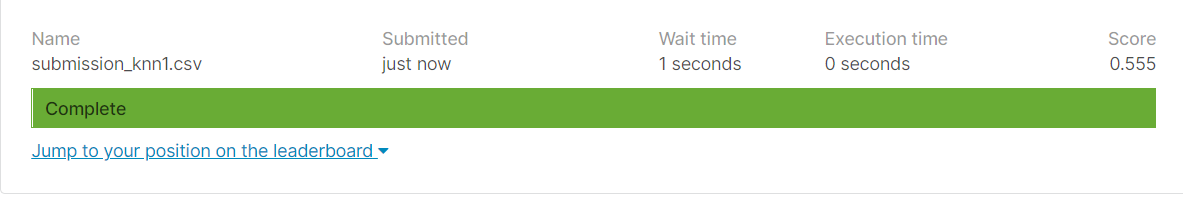

test_auc = 0.555

### Observation

As the first model, We have used KNN algorithm to trained the model with best parameter (algorithm='kd_tree',n_neighbours = 39) and got training AUC = 0.50 and Test_AUC = 0.55. It is less accurate but model is not overfitted.

**Logistic Regresstion Applied**

In [51]:
#ref= https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {'penalty':['l1','l2','elasticnet'],'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag','saga']}

#the instance  of Logistic Regression

log_model = LogisticRegression(random_state=42)

#Call Hyper-parameter function to get best hyperparameter tuning

log_clf = hyperparameter_model(log_model,params)



In [52]:
print(log_clf.best_params_)

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [53]:
from sklearn import linear_model

model = LogisticRegression(penalty='l1', C=1, solver='saga')

model.fit(X_train,y_train)

LogisticRegression(C=1, penalty='l1', solver='saga')

In [54]:
y_pred = model.predict(X_train)
print(y_pred)

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
train_auc_lr = roc_auc_score(y_train,y_pred)
print(train_auc_lr)

1.0


In [56]:
y_pred_lr_test = model.predict_proba(X_test)[:,1]
print(y_pred_lr_test)

[0.0296196  0.33341024 0.86344733 ... 0.87014075 0.99319125 0.17739898]


In [57]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_lr_test})


y_pred_lr_test.to_csv('submission_logs1.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.029620
1,251,0.333410
2,252,0.863447
3,253,0.997246
4,254,0.644034
5,255,0.386384
6,256,0.197760
7,257,0.420377
8,258,0.975555
9,259,0.187157


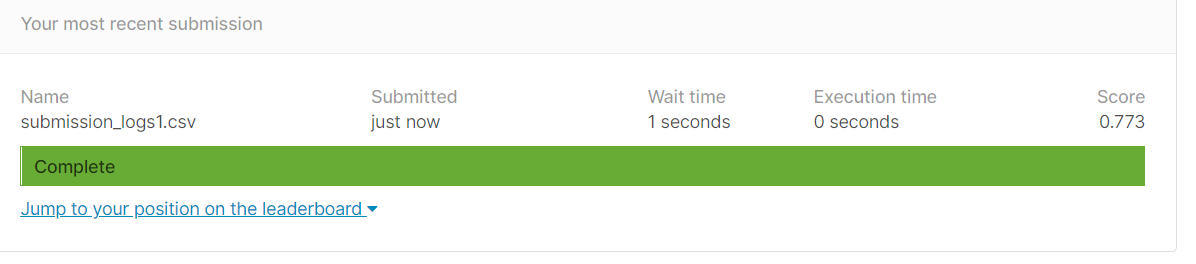

logistic_test_auc = 0.773

### Observation

We have used Logistic Regression algorithm to trained the model with best parameter (c=1,penalty=l1,solver=saga) and got training AUC = 1.0 and Test_AUC = 0.773. Training AUC is good and test auc litte bit down compare to training AUC.But it is decent.

**Support Vector Machine**

In [58]:
from sklearn.svm import SVC

In [60]:
#ref = https://scikit-learn.org/stable/modules/svm.html

params = {'C':[10**i for i in range(-4,5)],'kernel':['linear','poly','sigmoid','rdf']}

#The instance of SVC

svc_model = SVC(random_state=42)
#call the hyper-parameter function to get best parameters

svc_clf = hyperparameter_model(svc_model,params)

In [61]:
print(svc_clf.best_params_)

{'C': 1, 'kernel': 'poly'}


In [62]:
svc_clf = SVC(C = 1, kernel = 'poly',probability=True)
svc_clf.fit(X_train,y_train)

SVC(C=1, kernel='poly', probability=True)

In [63]:
y_pred = svc_clf.predict(X_train)
train_svm_auc = roc_auc_score(y_train,y_pred)
print(train_svm_auc)

1.0


In [64]:
y_pred_svc_test = svc_clf.predict_proba(X_test)[:,1]


In [65]:
y_pred_svc_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_svc_test})


y_pred_svc_test.to_csv('submission_svm1.csv', index=False)  
y_pred_svc_test.head(20)

,ID,Target
0,250,0.010239
1,251,0.799375
2,252,0.782953
3,253,0.776982
4,254,0.719545
5,255,0.762792
6,256,0.761592
7,257,0.770146
8,258,0.851095
9,259,0.745677


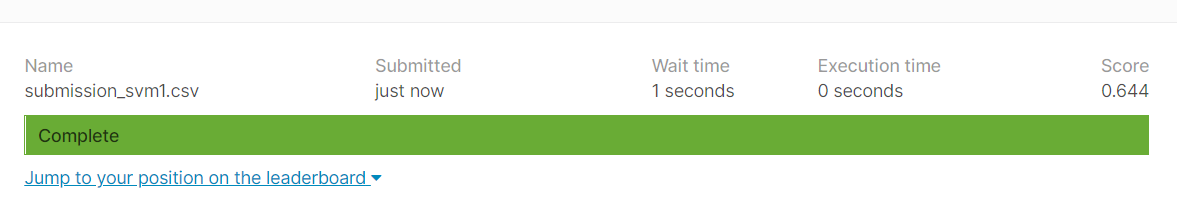

Test_SVM_auc = 0.644

### Observation

We have used Support Vector algorithm to trained the model with best parameter ('C': 1, 'kernel': 'Poly') and got training AUC = 1.0 and Test_AUC = 0.64. Training AUC is good and test auc a bit down compare to training AUC.But it is decent.

**Ensemble Model : Random Forest**

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'n_estimators': [10,20,30,40,50,60,100,200,300,400,500],'max_depth':[2,3,5,7,9]}

#The instance of model

rdf_model = RandomForestClassifier(random_state=42)

# Call the hyperparameter function  to get best parameter
rdf_clf = hyperparameter_model(rdf_model,params)


In [68]:
print(rdf_clf.best_params_)

{'max_depth': 5, 'n_estimators': 400}


In [69]:
rdf_clf = RandomForestClassifier(**rdf_clf.best_params_)
rdf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=400)

In [70]:
y_pred = rdf_clf.predict(X_train)
train_rdf_auc = roc_auc_score(y_train,y_pred)
print(train_rdf_auc)

1.0


In [71]:
y_pred_rdf_test = rdf_clf.predict_proba(X_test)[:,1]

In [72]:
y_pred_rdf_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_rdf_test})


y_pred_rdf_test.to_csv('submission_rdf1.csv', index=False)  
y_pred_rdf_test.head(20)

,ID,Target
0,250,0.516006
1,251,0.568699
2,252,0.575418
3,253,0.579637
4,254,0.535900
5,255,0.507414
6,256,0.512040
7,257,0.527653
8,258,0.630538
9,259,0.463896


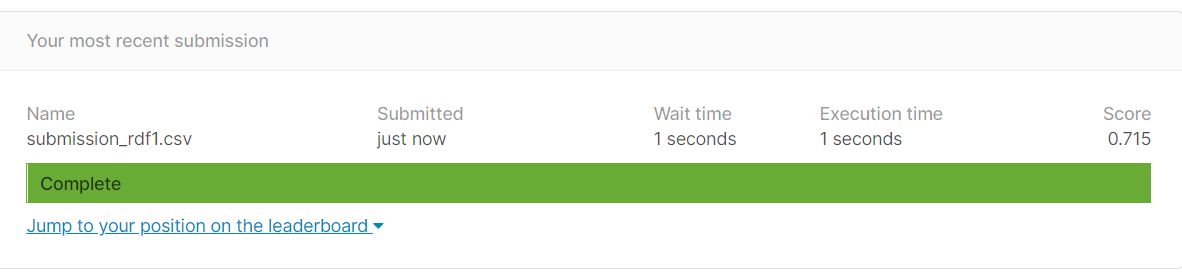

Test_rdf_auc : 0.715

### Observation

We have used Random Forest algorithm to trained the model with best parameter ('max_depth': 5, 'n_estimators': 400) and got training AUC = 1.0 and Test_AUC = 0.72. Model is accurate and it is not overfitted.

**Decision Tree Classifier**

In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
#ref =https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

params =  {'max_depth':[2,3,5,7,9],'criterion':['gini','entropy'],'min_samples_split':[2,3,4,5,6,]}

#The instance of Decision Tree Classifier

tree_model = DecisionTreeClassifier(random_state=42)

#Call Hyperparameter function to get best parameter

tree_clf = hyperparameter_model(tree_model,params)

In [97]:
print(tree_clf.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6}


In [98]:
tree_clf = DecisionTreeClassifier(**tree_clf.best_params_)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=6)

In [99]:
y_pred = tree_clf.predict(X_train)
train_tree_auc = roc_auc_score(y_train,y_pred)
print(train_tree_auc)

0.99375


In [100]:
y_pred_tree_test = tree_clf.predict_proba(X_test)[:,1]


In [101]:
y_pred_tree_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_tree_test})


y_pred_tree_test.to_csv('submission_tree1.csv', index=False)  
y_pred_tree_test.head(20)

,ID,Target
0,250,1.000000
1,251,0.000000
2,252,0.000000
3,253,1.000000
4,254,0.000000
5,255,0.000000
6,256,1.000000
7,257,1.000000
8,258,1.000000
9,259,0.000000


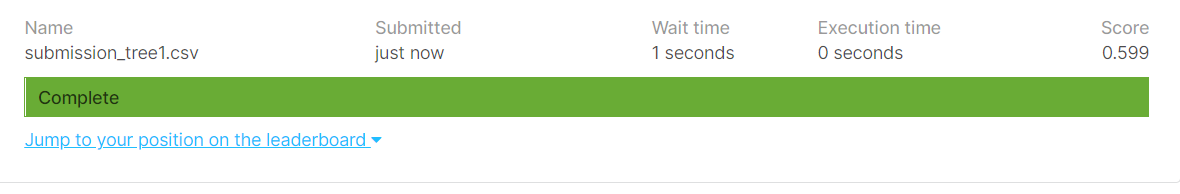

### Observation

Decision Tree is working poorly in this case

**XGBoost Classifier**

In [102]:
from xgboost import XGBClassifier

In [103]:
#list of hyper-parameter

params = {'max_depth':[2,3,5,7,9],'n_estimators':[10,20,30,40,50,100,200,400,500]}

# The instance of XGBClassifier

xg_model = XGBClassifier()
# call hyparameter function to get best parameter

xg_clf = hyperparameter_model(xg_model,params)

In [104]:
print(xg_clf.best_params_)

{'max_depth': 2, 'n_estimators': 400}


In [105]:
xg_clf = XGBClassifier(**xg_clf.best_params_)
xg_clf.fit(X_train,y_train)

XGBClassifier(max_depth=2, n_estimators=400)

In [107]:
y_pred = xg_clf.predict(X_train)

In [108]:
train_xgboost_auc = roc_auc_score(y_train,y_pred)
print(train_xgboost_auc)

1.0


In [109]:
y_pred_xg_test = xg_clf.predict_proba(X_test)[:,1]
print(y_pred_xg_test)

[0.7702675  0.4989509  0.2832494  ... 0.35014024 0.9550946  0.3850446 ]


In [110]:
y_pred_xg_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_xg_test})


y_pred_xg_test.to_csv('submission_xgboost1.csv', index=False)  
y_pred_xg_test.head(10)

,ID,Target
0,250,0.770267
1,251,0.498951
2,252,0.283249
3,253,0.995090
4,254,0.698269
5,255,0.321344
6,256,0.348547
7,257,0.270397
8,258,0.997484
9,259,0.552730


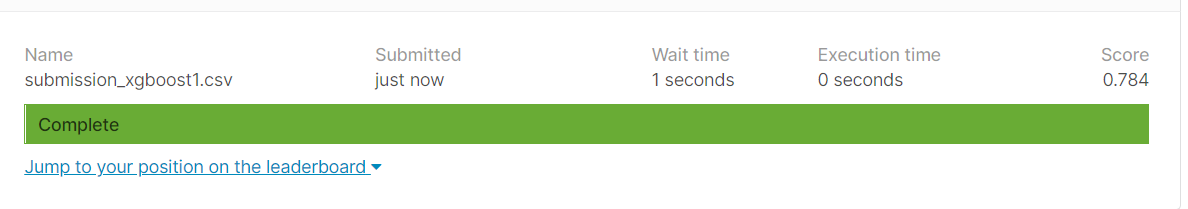

xgboost_test_auc = 0.784

### Observation

We have used Xgboost algorithm to trained the model with best parameter ('max_depth': 2, 'n_estimators': 400) and got training AUC = 1.0 and Test_AUC = 0.78. Model is accurate and it is not overfitted.

**Stacking Classifier**

In [111]:
import six
import sys
sys.modules['sklearn.externals.six'] = six


In [112]:
from mlxtend.classifier import StackingClassifier

In [113]:
#classifier 1
knn_model = KNeighborsClassifier(algorithm ='kd_tree',n_neighbors = 39)
knn_model.fit(X_train,y_train)

#Classifier 2
model = LogisticRegression(penalty='l1', C=1, solver='saga')
model.fit(X_train,y_train)

#Classifier 3
svc_clf = SVC(C =1, kernel = 'poly',probability=True)
svc_clf.fit(X_train,y_train)

#classifier 3

rdf_clf = RandomForestClassifier(max_depth=5, n_estimators=400)
rdf_clf.fit(X_train,y_train)
#classifier 4

tree_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 9, min_samples_split = 6)
tree_clf.fit(X_train,y_train)

#classifier 5
xg_clf = XGBClassifier(max_depth = 2, n_estimators = 400)
xg_clf.fit(X_train,y_train)


#Stacking Classifer

sclf = StackingClassifier(classifiers=[knn_model,model,svc_clf,rdf_clf,tree_clf,xg_clf],meta_classifier=model,use_probas=True)

#fit the model
sclf.fit(X_train,y_train)

#predict in probabilities

y_pred = sclf.predict(X_train)


In [114]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

1.0


In [115]:
y_pred_stack_test = sclf.predict_proba(X_test)[:,1]

In [116]:
y_pred_stack_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_stack_test})


y_pred_stack_test.to_csv('submission_stack1.csv', index=False)  
y_pred_stack_test.head(20)

,ID,Target
0,250,0.384830
1,251,0.664552
2,252,0.444153
3,253,0.984780
4,254,0.739978
5,255,0.819734
6,256,0.833805
7,257,0.795113
8,258,0.989374
9,259,0.650674


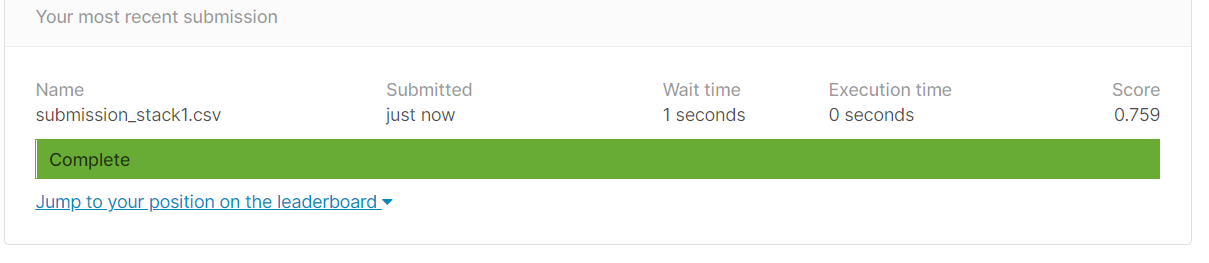

### Summary of All Models

In [1]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Model','Hyper-parameter','Train AUC','Test AUC'],['Knn_Model',r"(algorithm='kd_tree', n_neighbors=39)",0.50,0.55],
           ['logistic Regresstion',r"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",1.0,0.77],['Support Vector Machine',
           r"{'C': 1, 'kernel': 'poly'}",1.0,0.64],['XGBoost Classifier',r"{'max_depth': 2, 'n_estimators': 400}",1.00,0.78],
            ['Decision_tree Model',r"{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6}",0.99,0.59],['Random forest',r"{'max_depth': 5, 'n_estimators': 400}",1.00,0.71],
            ['Calibrated Model',"--",1.00,0.76]])

print(t.draw())

+------------------------+------------------------------+-----------+----------+
|         Model          |       Hyper-parameter        | Train AUC | Test AUC |
+========================+==============================+===========+==========+
| Knn_Model              | (algorithm='kd_tree',        | 0.500     | 0.550    |
|                        | n_neighbors=39)              |           |          |
+------------------------+------------------------------+-----------+----------+
| logistic Regresstion   | {'C': 1, 'penalty': 'l1',    | 1         | 0.770    |
|                        | 'solver': 'saga'}            |           |          |
+------------------------+------------------------------+-----------+----------+
| Support Vector Machine | {'C': 1, 'kernel': 'poly'}   | 1         | 0.640    |
+------------------------+------------------------------+-----------+----------+
| XGBoost Classifier     | {'max_depth': 2,             | 1         | 0.780    |
|                        | '

We have used Calibrated Classifier and got training AUC = 1.0 and test AUC = 0.76

As per observation, XGboost is giving Good Accuracy from above applied algorithm